In [1]:
%%writefile wave_config.yaml

date:
    start: 2018-10-1 00:00:00
    stop:  2018-10-7 00:00:00

run_name: "latest"

region:
    bbox: [-72, 40, -68, 44]
    crs: "urn:ogc:def:crs:OGC:1.3:CRS84"

sos_name: "waves"

cf_names:
    - sea_surface_wave_significant_height
    - sea_surface_wind_wave_significant_height

units: "m"

catalogs:
    - https://data.ioos.us/csw

Overwriting wave_config.yaml


In [2]:
import os
import shutil
from datetime import datetime
from ioos_tools.ioos import parse_config


config = parse_config("wave_config.yaml")

save_dir = os.path.abspath(config["run_name"])
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
os.makedirs(save_dir)


fmt = "{:*^64}".format
print(fmt(f"Saving data inside directory {save_dir}"))
print(fmt(" Run information "))
print(f"Run date: {datetime.utcnow():%Y-%m-%d %H:%M:%S}")
print(f"Start: {config['date']['start']:%Y-%m-%d %H:%M:%S}")
print(f"Stop: {config['date']['stop']:%Y-%m-%d %H:%M:%S}")
print("Bounding box: {0:3.2f}, {1:3.2f},"
      "{2:3.2f}, {3:3.2f}".format(*config["region"]["bbox"]))

Saving data inside directory /home/filipe/Dropbox/Meetings/2019-PythonBrasil/weather_app/notebooks/latest
*********************** Run information ************************
Run date: 2019-10-16 15:34:02
Start: 2018-10-01 00:00:00
Stop: 2018-10-07 00:00:00
Bounding box: -72.00, 40.00,-68.00, 44.00


In [3]:
from skillscore import make_filter


filter_list = make_filter(config)

In [4]:
from ioos_tools.ioos import service_urls, get_csw_records
from owslib.csw import CatalogueServiceWeb


dap_urls = []
print(fmt(" Catalog information "))
for endpoint in config["catalogs"]:
    print(f"URL: {endpoint}")
    try:
        csw = CatalogueServiceWeb(endpoint, timeout=120)
    except Exception as e:
        print(f"{e}")
        continue
    csw = get_csw_records(csw, filter_list, esn="full")
    OPeNDAP = service_urls(csw.records, identifier="OPeNDAP:OPeNDAP")
    odp = service_urls(csw.records, identifier="urn:x-esri:specification:ServiceType:odp:url")
    dap = OPeNDAP + odp
    dap_urls.extend(dap)

    print(f"Number of datasets available: {len(csw.records.keys())}")

    for rec, item in csw.records.items():
        print(f"{item.title}")
    if dap:
        print(fmt(" DAP "))
        for url in dap:
            print(f"{url}.html")
    print("\n")

# Get only unique endpoints.
dap_urls = list(set(dap_urls))

********************* Catalog information **********************
URL: https://data.ioos.us/csw
Number of datasets available: 5
A01 Directional Waves
B01 Directional Waves
Coupled Northwest Atlantic Prediction System (CNAPS)
E01 Directional Waves
NDBC Standard Meteorological Buoy Data, 1970-present
***************************** DAP ******************************
http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc.html




In [5]:
from ioos_tools.ioos import is_station


non_stations = []
for url in dap_urls:
    try:
        if not is_station(url):
            non_stations.append(url)
    except (RuntimeError, OSError, IOError) as e:
        print(f"Could not access URL {url}. {e}")

dap_urls = non_stations
print(fmt(" Filtered DAP "))
for url in dap_urls:
    print(f"{url}.html")

************************* Filtered DAP *************************
http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc.html


In [6]:
from pyoos.collectors.ndbc.ndbc_sos import NdbcSos

collector_ndbc = NdbcSos()

collector_ndbc.set_bbox(config["region"]["bbox"])
collector_ndbc.end_time = config["date"]["stop"]
collector_ndbc.start_time = config["date"]["start"]
collector_ndbc.variables = [config["sos_name"]]

ofrs = collector_ndbc.server.offerings
title = collector_ndbc.server.identification.title
print(fmt(" NDBC Collector offerings "))
print(f"{title}: {len(ofrs)} offerings")

******************* NDBC Collector offerings *******************
National Data Buoy Center SOS: 1075 offerings


In [7]:
import pandas as pd
from ioos_tools.ioos import collector2table


ndbc = collector2table(
    collector=collector_ndbc,
    config=config,
    col="sea_surface_wave_significant_height (m)"
)

if ndbc:
    data = {
        "station_name": [s._metadata.get("station_name") for s in ndbc],
        "station_code": [s._metadata.get("station_code") for s in ndbc],
        "sensor": [s._metadata.get("sensor") for s in ndbc],
        "lon": [s._metadata.get("lon") for s in ndbc],
        "lat": [s._metadata.get("lat") for s in ndbc],
        "depth": [s._metadata.get("depth") for s in ndbc],
    }

table = pd.DataFrame(data).set_index("station_code")
table

,station_name,sensor,lon,lat,depth
station_code,,,,,
44005,"GULF OF MAINE - 78 NM East of Portsmouth, NH",urn:ioos:sensor:wmo:44005::wpm1,-69.128,43.201,None
44007,"PORTLAND - 12 NM Southeast of Portland,ME",urn:ioos:sensor:wmo:44007::wpm1,-70.141,43.525,None
44013,"BOSTON 16 NM East of Boston, MA",urn:ioos:sensor:wmo:44013::wpm1,-70.651,42.346,None
44018,"CAPE COD - 9 NM North of Provincetown, MA",urn:ioos:sensor:wmo:44018::wpm1,-70.143,42.206,None
44030,Buoy B01 - Western Maine Shelf,urn:ioos:sensor:wmo:44030::summarywav1,-70.426,43.179,None
44032,Buoy E01 - Central Maine Shelf,urn:ioos:sensor:wmo:44032::summarywav1,-69.355,43.715,None
44090,"Cape Cod Bay, MA (221)",urn:ioos:sensor:wmo:44090::summarywav1,-70.329,41.840,None
44097,"Block Island, RI (154)",urn:ioos:sensor:wmo:44097::summarywav1,-71.127,40.969,None
44098,"Jeffrey's Ledge, NH (160)",urn:ioos:sensor:wmo:44098::summarywav1,-70.168,42.798,None


In [8]:
data = ndbc

index = pd.date_range(
    start=config["date"]["start"].replace(tzinfo=None),
    end=config["date"]["stop"].replace(tzinfo=None),
    freq="1H"
)

# Preserve metadata with `reindex`.
observations = []
for series in data:
    _metadata = series._metadata
    series.index = series.index.tz_localize(None)
    obs = series.reindex(index=index, limit=1, method="nearest")
    obs._metadata = _metadata
    # FIXME: remove this!
    obs._metadata["standard_name"] = "sea_surface_wave_significant_height"

    observations.append(obs)

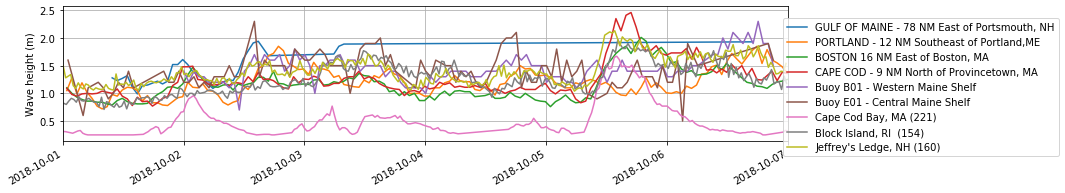

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(13, 2.75))
for series in data:
    series.plot(ax=ax, label=series._metadata["station_name"])
    plt.legend(bbox_to_anchor=(1.38, 0.95), loc="upper right")
    ax.grid(True)
    ax.set_ylabel("Wave height (m)")
    ax.set_xlabel("")

In [10]:
import iris
from ioos_tools.tardis import series2cube


attr = {
    "featureType": "timeSeries",
    "Conventions": "CF-1.6",
    "standard_name_vocabulary": "CF-1.6",
    "cdm_data_type": "Station",
    "comment": "Data from http://opendap.co-ops.nos.noaa.gov",
}


cubes = iris.cube.CubeList(
    [series2cube(obs, attr=attr) for obs in observations]
)

outfile = os.path.join(save_dir, "OBS_DATA.nc")
iris.save(cubes, outfile)

In [11]:
from skillscore import check_standard_name
from iris.exceptions import (CoordinateNotFoundError, ConstraintMismatchError,
                             MergeError)
from ioos_tools.ioos import get_model_name
from ioos_tools.tardis import quick_load_cubes, proc_cube, is_model


print(fmt(" Models "))
cubes = {}
for k, url in enumerate(dap_urls):
    print(f"\n[Reading url {k+1}/{len(dap_urls)}]: {url}")
    if not check_standard_name(url, config["cf_names"]):
        print(f"Could not find {config['cf_names']} in {url}")
        continue
    try:
        cube = quick_load_cubes(url, config["cf_names"],
                                callback=None, strict=True)
        if is_model(cube):
            cube = proc_cube(cube,
                             bbox=config["region"]["bbox"],
                             time=(config["date"]["start"],
                                   config["date"]["stop"]),
                             units=config["units"])
        else:
            print(f"[Not model data]: {url}")
            continue
        mod_name = get_model_name(url)
        cubes.update({mod_name: cube})
    except (RuntimeError, ValueError,
            ConstraintMismatchError, CoordinateNotFoundError,
            IndexError) as e:
        print(f"Cannot get cube for: {url}\n{e}")

**************************** Models ****************************

[Reading url 1/1]: http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc


/home/filipe/miniconda3/envs/PyBr19/lib/python3.7/site-packages/iris/fileformats/cf.py:1069: UserWarning: Ignoring formula terms variable 'zeta' referenced by data variable 'u' via variable 's_rho': Dimensions ('time', 'eta_rho', 'xi_rho') do not span ('time', 's_rho', 'eta_u', 'xi_u')
  warnings.warn(msg)
/home/filipe/miniconda3/envs/PyBr19/lib/python3.7/site-packages/iris/fileformats/cf.py:1069: UserWarning: Ignoring formula terms variable 'h' referenced by data variable 'u' via variable 's_rho': Dimensions ('eta_rho', 'xi_rho') do not span ('time', 's_rho', 'eta_u', 'xi_u')
  warnings.warn(msg)
/home/filipe/miniconda3/envs/PyBr19/lib/python3.7/site-packages/iris/fileformats/cf.py:1069: UserWarning: Ignoring formula terms variable 'zeta' referenced by data variable 'v' via variable 's_rho': Dimensions ('time', 'eta_rho', 'xi_rho') do not span ('time', 's_rho', 'eta_v', 'xi_v')
  warnings.warn(msg)
/home/filipe/miniconda3/envs/PyBr19/lib/python3.7/site-packages/iris/fileformats/cf.py:

In [12]:
import iris
from iris.pandas import as_series
from ioos_tools.tardis import (make_tree, get_nearest_water,
                               add_station, ensure_timeseries)

for mod_name, cube in cubes.items():
    fname = f"{mod_name}.nc"
    fname = os.path.join(save_dir, fname)
    print(fmt(f" Downloading to file {fname} "))
    try:
        tree, lon, lat = make_tree(cube)
    except CoordinateNotFoundError as e:
        print(f"Cannot make KDTree for: {mod_name}")
        continue
    # Get model series at observed locations.
    raw_series = {}
    for obs in observations:
        obs = obs._metadata
        station = obs["station_code"]
        try:
            kw = {"k": 10, "max_dist": 0.08, "min_var": 0.01}
            args = cube, tree, obs["lon"], obs["lat"]
            try:
                series, dist, idx = get_nearest_water(*args, **kw)
            except RuntimeError as e:
                print("Cannot download {!r}.\n{}".format(cube, e))
                series = None
        except ValueError as e:
            status = "No Data"
            print(f"[{status}] {obs['station_name']}")
            continue
        if not series:
            status = "Land   "
        else:
            raw_series.update({station: series})
            series = as_series(series)
            status = "Water  "
        print(f"[{status}] {obs['station_name']}")
    if raw_series:  # Save cube.
        for station, cube in raw_series.items():
            cube = add_station(cube, station)
        try:
            cube = iris.cube.CubeList(raw_series.values()).merge_cube()
        except MergeError as e:
            print(e)
        ensure_timeseries(cube)
        try:
            iris.save(cube, fname)
        except AttributeError:
            # FIXME: we should patch the bad attribute instead of removing everything.
            cube.attributes = {}
            iris.save(cube, fname)
        del cube
    print(f"Finished processing [{mod_name}]")

[Water  ] GULF OF MAINE - 78 NM East of Portsmouth, NH
[Water  ] PORTLAND - 12 NM Southeast of Portland,ME
[Water  ] BOSTON 16 NM East of Boston, MA
[Water  ] CAPE COD - 9 NM North of Provincetown, MA
[Water  ] Buoy B01 - Western Maine Shelf
[Water  ] Buoy E01 - Central Maine Shelf
[Water  ] Cape Cod Bay, MA (221)
[Water  ] Block Island, RI  (154)
[Water  ] Jeffrey's Ledge, NH (160)
Finished processing [SECOORA_NCSU_CNAPS]


In [13]:
from ioos_tools.ioos import load_ncs
from ioos_tools.skill_score import mean_bias, apply_skill

dfs = load_ncs(config)

df = apply_skill(
    dfs,
    mean_bias,
    remove_mean=False,
    filter_tides=False,
)
skill_score = {"mean_bias": df.to_dict()}

# Filter out stations with no valid comparison.
df.dropna(how="all", axis=1, inplace=True)
df = df.applymap("{:.2f}".format).replace("nan", "--")

In [14]:
from ioos_tools.skill_score import rmse

dfs = load_ncs(config)

df = apply_skill(dfs, rmse, remove_mean=True, filter_tides=False)
skill_score["rmse"] = df.to_dict()

# Filter out stations with no valid comparison.
df.dropna(how="all", axis=1, inplace=True)
df = df.applymap("{:.2f}".format).replace("nan", "--")

In [15]:
import pandas as pd

# Stringfy keys.
for key in skill_score.keys():
    skill_score[key] = {str(k): v for k, v in skill_score[key].items()}

mean_bias = pd.DataFrame.from_dict(skill_score["mean_bias"])
mean_bias = mean_bias.applymap("{:.2f}".format).replace("nan", "--")

skill_score = pd.DataFrame.from_dict(skill_score["rmse"])
skill_score = skill_score.applymap("{:.2f}".format).replace("nan", "--")

In [16]:
from skillscore import make_map


bbox = config["region"]["bbox"]

m = make_map(
    bbox,
    zoom_start=9,
    line=True,
    layers=True
)

In [17]:
from glob import glob
from operator import itemgetter

import iris
import folium
from folium.plugins import MarkerCluster
from ioos_tools.ioos import stations_keys


all_obs = stations_keys(config)

big_list = []
for fname in glob(os.path.join(save_dir, "*.nc")):
    if "OBS_DATA" in fname:
        continue
    cube = iris.load_cube(fname)
    model = os.path.split(fname)[1].split("-")[-1].split(".")[0]
    lons = cube.coord(axis="X").points
    lats = cube.coord(axis="Y").points
    stations = cube.coord("station_code").points
    models = [model] * lons.size
    lista = zip(models, lons.tolist(), lats.tolist(), stations.tolist())
    big_list.extend(lista)

big_list.sort(key=itemgetter(3))
df = pd.DataFrame(big_list, columns=["name", "lon", "lat", "station"])
df.set_index("station", drop=True, inplace=True)
groups = df.groupby(df.index)


locations, popups = [], []
for station, info in groups:
    sta_name = all_obs[station].replace("'", "")
    for lat, lon, name in zip(info.lat, info.lon, info.name):
        locations.append([lat, lon])
        popups.append("[{}]: {}".format(name, sta_name))

MarkerCluster(locations=locations, popups=popups, name="Cluster").add_to(m);

In [18]:
from skillscore import make_plot, get_df, make_marker


for station in dfs["OBS_DATA"].columns:
    sta_name = all_obs[station].replace("'", "")
    df = get_df(dfs, station)
    if df.empty:
        continue
    p = make_plot(df, station, skill_score, mean_bias)
    marker = make_marker(p, station, config)
    marker.add_to(m)

folium.LayerControl().add_to(m);

In [19]:
m